In [66]:
import geopandas as gpd
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import SNOTEL_SWE
# Import data
df = pd.read_csv (r'SNOTEL_SWE.Mesa_Lakes2020.csv')
site_flg = 'SNOTEL. Mesa Lakes 2000'
data_flg = 'Snow Water Equivalent (mm)'
#df.columns

data = df[[data_flg]]  
data_num = data.to_numpy()                # pandas.core.frame.DataFrame -> numpy.ndarray 
data_arr = np.zeros(len(date))
for ii in range(0,len(date)):
    a = np.array(data_num[ii])
    data_arr[ii] = a.item()   
    
ts = pd.Timestamp('2019-10-01-01T00:00:00') 
ts_jan1 = pd.Timestamp('2019-01-01-01T00:00:00')
doy_arr = (ts.to_julian_date() - ts_jan1.to_julian_date()) + range(len(data_arr))
for ii in range(0,len(date)):
        doy_arr[ii] = doy_arr[ii]-365

In [67]:
# Generate the beginning and end-pleatau for a better fitting
tmp = np.zeros(2)
data_arr2 = tmp.tolist()
data_flt = data_arr.tolist()
data_arr2.extend(data_flt)
data_arr2.extend(tmp.tolist())

doy_arr2 = [-100,-90]
doy_flt = doy_arr.tolist()
doy_arr2.extend(doy_flt)
doy_arr2.extend([190,200])       

Fitted parameters: [-1.54520190e+00  2.93505695e+02  3.17024044e-02  3.15612366e+00
  3.58335719e-01  1.22821728e+02]
RMSE: 12.531672307384504
R-squared: 0.9864448132580266

DOY at the wet-SMT: 133.58320535473334
DOY at the peak-SWE: 107.0



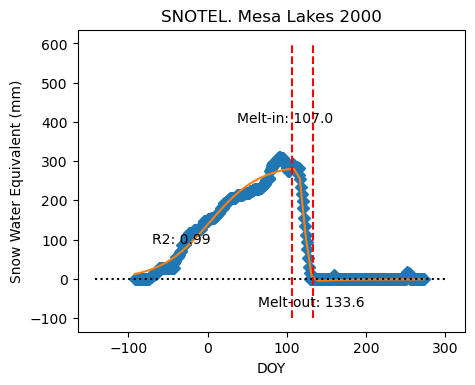

In [68]:
### Fitting double logistic/sigmoid curves
# code credit: https://stackoverflow.com/questions/56329180/fitting-a-logistic-curve-to-data
# https://geog0111.readthedocs.io/en/latest/Chapter7_FittingPhenologyModels.html

import pandas as pd
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

# Import data
yData = numpy.array(data_arr)
xData = numpy.array(doy_arr)
# xData = numpy.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0])
# yData = numpy.array([0.073, 2.521, 15.879, 48.365, 72.68, 90.298, 92.111, 93.44, 93.439, 93.389, 93.381, 93.367, 93.94, 93.269, 96.376])

# Define function
def func(x, a, b, c, d, e, f):
    sigma1 = 1./(1+np.exp(c*(x-d)))
    sigma2 = 1./(1+np.exp(-e*(x-f)))
    return a - b*(sigma1 + sigma2 - 1)

# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)

# LAI double-log fit best param: [0.46 5.04 0.12 126 0.09 268]
def generate_Initial_Parameters():
    parameterBounds = []
    #parameterBounds.append([0.0, 10.0]) # search bounds for a (bottom-value)
    #parameterBounds.append([-10.0, 10.0]) # search bounds for b (top-value)
    #parameterBounds.append([0.0, 0.5]) # search bounds for c (kinda slope)
    #parameterBounds.append([90.0, 120.0]) # search bounds for d (x-value of the middle slope)

    parameterBounds.append([140.0, 160.0]) # search bounds for a (bottom-value)
    parameterBounds.append([350.0, 450.0]) # search bounds for b (top-value)   
    parameterBounds.append([0.0, 0.5])     # search bounds for c (kinda slope)
    parameterBounds.append([50.0, 120.0])  # search bounds for d (x-value of the middle slope)
    parameterBounds.append([0, 0.5])       # search bounds for e (kinda slope)
    parameterBounds.append([100.0, 150.0]) # search bounds for f (x-value of the middle slope)    
    
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

# by default, differential_evolution completes by calling curve_fit() using parameter bounds
geneticParameters = generate_Initial_Parameters()

# now call curve_fit without passing bounds from the genetic algorithm,
# just in case the best fit parameters are aoutside those bounds
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
print('Fitted parameters:', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) # squared errors
MSE = numpy.mean(SE) # mean squared errors
RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))

print('RMSE:', RMSE)
print('R-squared:', Rsquared)
print()

##########################################################
# find the wet-SMT
x_data = np.array(range(200))
y_data = np.array(func(x_data, *fittedParameters))
y_thres = 0 # y-value threshold for the DOY

order = y_data.argsort() # sort the arrays
y_data = y_data[order]
x_data = x_data[order]
      
# call the interpolation function but reverse the array datasets to find the corresponding x value       
tmg = np.interp(y_thres, y_data, x_data,  left=None, right=None, period=None)
print('DOY at the wet-SMT:', tmg)

##########################################################
# find the peak-SWE
x_data = np.array(range(200))
y_data = np.array(func(x_data, *fittedParameters))
y_thres = max(y_data) # y-value threshold for the DOY

order = y_data.argsort() # sort the arrays
y_data = y_data[order]
x_data = x_data[order]
      
# call the interpolation function but reverse the array datasets to find the corresponding x value       
tmg_pk = np.interp(y_thres, y_data, x_data,  left=None, right=None, period=None)
print('DOY at the peak-SWE:', tmg_pk)
print()

##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot
    axes.plot(xModel, yModel)
    
    # plot the timing-vertical line and 0-0 line
    plt.plot([min(xData)-50, max(xData)+30],[0,0],':k')
    plt.plot([tmg,tmg],[-100,600],'--r')
    plt.plot([tmg_pk,tmg_pk],[-100,600],'--r')

    plt.text(-70, 90, 'R2: '+ "{:.2f}".format(Rsquared))
    plt.text(tmg-70, -70, 'Melt-out: '+ "{:.1f}".format(tmg))
    plt.text(tmg_pk-70, 400, 'Melt-in: '+ "{:.1f}".format(tmg_pk))
    
    plt.xlabel('DOY')
    plt.ylabel(data_flg)
    plt.title(site_flg)
    
    plt.show()
    plt.close('all') # clean up after using pyplot

graphWidth = 500
graphHeight = 400
ModelAndScatterPlot(graphWidth, graphHeight)